<a href="https://colab.research.google.com/github/jnpos/group8_ECG/blob/Development/ECG_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!git clone https://github.com/jveenland/tm10007_ml.git

Cloning into 'tm10007_ml'...
remote: Enumerating objects: 83, done.
remote: Counting objects: 100% (22/22), done.
remote: Compressing objects: 100% (10/10), done.
remote: Total 83 (delta 13), reused 12 (delta 12), pack-reused 61
Unpacking objects: 100% (83/83), 67.93 MiB | 7.77 MiB/s, done.


In [ ]:
# General packages
import numpy as np 
import matplotlib.pyplot as plt
from sklearn import datasets as ds
from sklearn import metrics
import zipfile
import os
import pandas as pd

# Metrics
#from sklearn.metrics import confusion_matrix
#from sklearn.metrics import mean_absolute_error
# from sklearn.metrics import r2_score

# Classifiers
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn import model_selection
from sklearn import preprocessing

In [ ]:
with zipfile.ZipFile('/content/tm10007_ml/ecg/ecg_data.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/tm10007_ml/ecg')

data = pd.read_csv('/content/tm10007_ml/ecg/ecg_data.csv', index_col=0)

print(f'The number of samples: {len(data.index)}')
print(f'The number of columns: {len(data.columns)}')



The number of samples: 827
The number of columns: 9001


**Split input, output, test and train data:**

In [31]:
# Find column with label 
bool_cols = [col for col in data 
             if np.isin(data[col].dropna().unique(), [0, 1]).all()]
loc_label = data.columns.get_loc('label')

# Determine data and output 
y = data['label']
x = pd.DataFrame()
x = data.drop(data.columns[loc_label],axis=1)

# Split test and trainingsdata 
x_train, x_test, y_train, y_test = model_selection.train_test_split(x, y,test_size=0.25,random_state=0,stratify=y)



**Scaling:**

In [10]:
# SCALEN
scaler = preprocessing.RobustScaler()
scaler.fit(x_train)
x_train = pd.DataFrame(scaler.transform(x_train))

# Niet fitten op test, alleen toepassen


**Checking if data is normally distributed:**


In [11]:
# Checking if data is normally distributed  

from scipy.stats import shapiro  
shapiro(x_train)

amount_normallydistributed = 0
for column in x_train.columns:
  result = shapiro(x_train[column])
  normallydistributed = result.pvalue > 0.05
  amount_normallydistributed += normallydistributed 
  
print(amount_normallydistributed, "features are normally distributed features")


/usr/local/lib/python3.9/dist-packages/scipy/stats/_morestats.py:1816: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


0 features are normally distributed features


**PCA:**

In [32]:
# PCA
n_samples = len(x_train)
n_features = len(x_train.columns)
n_features = min((n_samples-1), n_features)
print(n_features)

p = PCA(n_components=n_features)
p = p.fit(x_train)
x_pca = p.transform(x_train)

print(f'result pca: {x_pca.shape}')

619
result pca: (620, 619)


**Feature selection:**

In [33]:
# Feature selection

# Univariate & f_classif
from sklearn.feature_selection import SelectKBest, f_classif

selector = SelectKBest(f_classif,k="all")
selector.fit(x_pca,y_train)
scores = -np.log10(selector.pvalues_)
scores /= scores.max()

dataframe = pd.DataFrame()
dataframe = selector.pvalues_

print(len(selector.pvalues_[selector.pvalues_<0.05]))

fs = SelectKBest(score_func=f_classif, k=len(selector.pvalues_[selector.pvalues_<0.05]))
X_univariate = fs.fit_transform(x_pca, y_train)
print(f'result univariate: {X_univariate.shape}')

# Elastic net --> is dit wel een goede fs?
from sklearn.linear_model import ElasticNet
from sklearn.feature_selection import SelectFromModel

ENreg = ElasticNet(alpha=1, l1_ratio=0.5).fit(x_pca,y_train)
model_ENreg = SelectFromModel(ENreg, prefit=True)
x_ENreg = model_ENreg.transform(x_pca)

print(f'result Elastic Net: {x_ENreg.shape}')

#x_ENreg = pd.DataFrame(x_ENreg)


28
result univariate: (620, 28)
result Elastic Net: (620, 104)


**Learning curve with accuracy as metric**

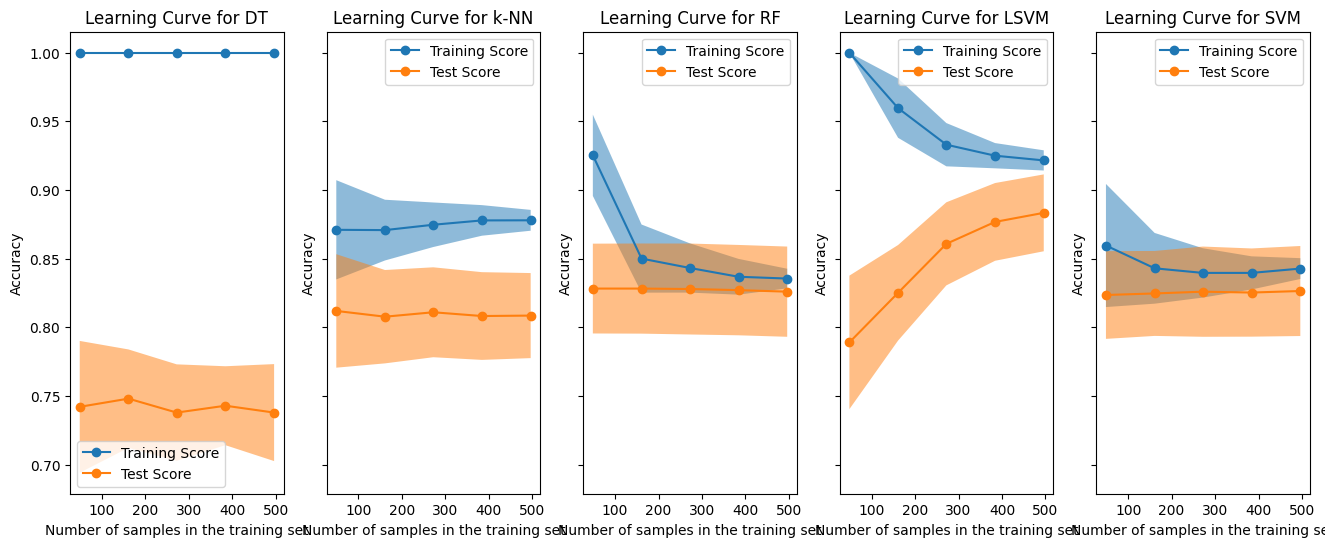

In [13]:
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
from sklearn.svm import LinearSVC
from sklearn import svm


# lda = LinearDiscriminantAnalysis(solver="svd", store_covariance=True)
knn = KNeighborsClassifier(n_neighbors=3)
tree = tree.DecisionTreeClassifier()
lsvc = make_pipeline(StandardScaler(), LinearSVC(random_state=0, tol=1e-5))
svm = svm.SVC()
# svc = make_pipeline(StandardScaler(), SVC(gamma='auto'))
rf = RandomForestClassifier(max_depth=2, random_state=0)
# nn = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(), random_state=1)


import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import LearningCurveDisplay, ShuffleSplit

fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(16, 6), sharey=True)

common_params = {
    "X": X_univariate,
    "y": y_train,
    "train_sizes": np.linspace(0.1, 1.0, 5),
    "cv": ShuffleSplit(n_splits=50, test_size=0.2, random_state=0),
    "score_type": "both",
    "n_jobs": 4,
    "line_kw": {"marker": "o"},
    "std_display_style": "fill_between",
    "score_name": "Accuracy",
}
title = ['DT', 'k-NN', 'RF', 'LSVM', 'SVM']

for ax_idx, estimator in enumerate([tree, knn, rf, lsvc, svm]):
    LearningCurveDisplay.from_estimator(estimator, **common_params, ax=ax[ax_idx])
    handles, label = ax[ax_idx].get_legend_handles_labels()
    ax[ax_idx].legend(handles[:2], ["Training Score", "Test Score"])
    ax[ax_idx].set_title(f"Learning Curve for {title[ax_idx]}")

**Learning curves with F2 without hyperparameter optimization**

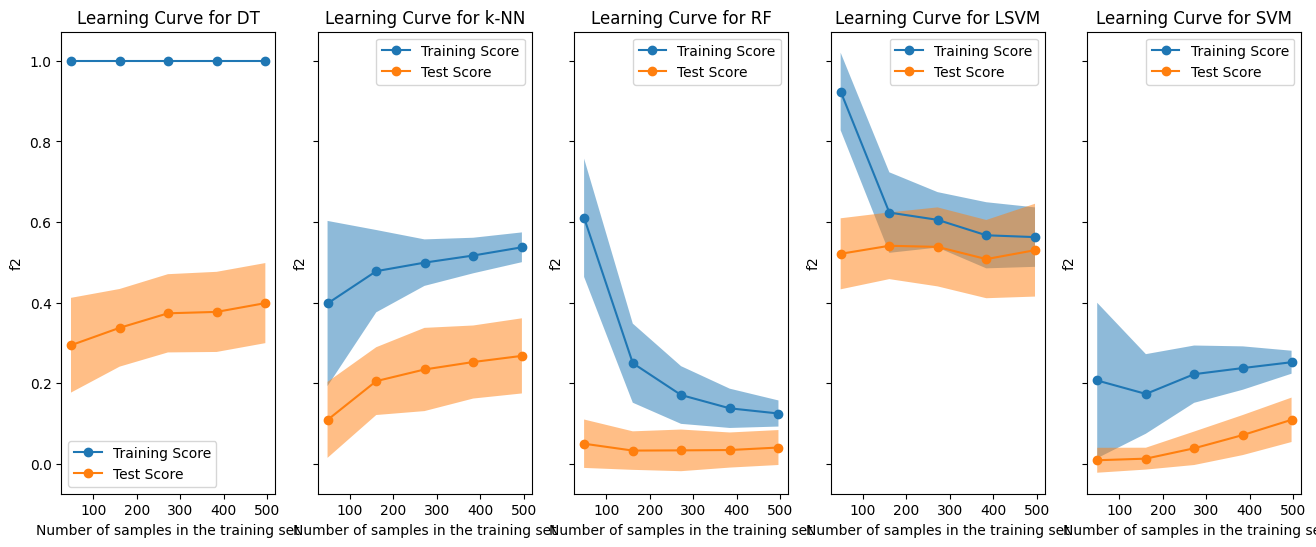

In [50]:
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
from sklearn.svm import LinearSVC
from sklearn import svm
from sklearn.metrics import fbeta_score, make_scorer

# define f_beta as a scorer
# beta < 1 lends more weight to precision, while beta > 1 favors recall
f_beta = make_scorer(fbeta_score, beta=2)

knn = KNeighborsClassifier(n_neighbors=3)
tree = tree.DecisionTreeClassifier()
l_svm = LinearSVC()
svm = svm.SVC()
rf = RandomForestClassifier(max_depth=2, random_state=0)

import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import LearningCurveDisplay, ShuffleSplit

fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(16, 6), sharey=True)

common_params = {
    "X": X_univariate,
    "y": y_train,
    "train_sizes": np.linspace(0.1, 1.0, 5),
    "cv": ShuffleSplit(n_splits=50, test_size=0.2, random_state=0),
    "score_type": "both",
    "n_jobs": 4,
    "line_kw": {"marker": "o"},
    "std_display_style": "fill_between",
    "score_name": "f2",
    "scoring": f_beta
}
title = ['DT', 'k-NN', 'RF', 'LSVM', 'SVM']

for ax_idx, estimator in enumerate([tree, knn, rf, l_svm, svm]):
    LearningCurveDisplay.from_estimator(estimator, **common_params, ax=ax[ax_idx])
    handles, label = ax[ax_idx].get_legend_handles_labels()
    ax[ax_idx].legend(handles[:2], ["Training Score", "Test Score"])
    ax[ax_idx].set_title(f"Learning Curve for {title[ax_idx]}")

**Learning curves with F2 and hyperparameter optimization**

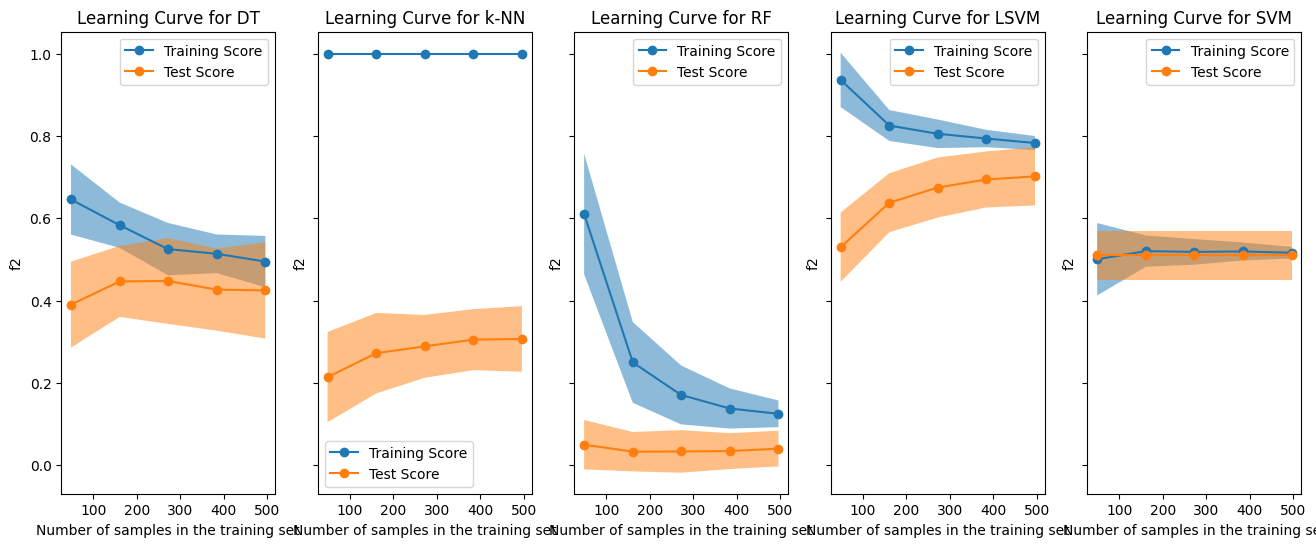

In [56]:
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
from sklearn.svm import LinearSVC
from sklearn import svm
from sklearn.metrics import fbeta_score, make_scorer

# define f_beta as a scorer
# beta < 1 lends more weight to precision, while beta > 1 favors recall
f_beta = make_scorer(fbeta_score, beta=2)

knn = KNeighborsClassifier(weights='distance', p= 1, n_neighbors= 2, leaf_size = 46, algorithm='auto')
tree = DecisionTreeClassifier(splitter= 'random', min_weight_fraction_leaf= 0.125, min_samples_split= 6, min_samples_leaf= 8, max_features = None, criterion= 'gini', class_weight='balanced')
l_svm = LinearSVC(tol= 0.0001, penalty= 'l1', loss= 'squared_hinge', intercept_scaling= 2.0, fit_intercept= True, dual= False, class_weight= 'balanced', C=0.01)
svm = svm.SVC(tol= 100.0, shrinking=False, probability=False, kernel='poly', gamma='auto', degree=2, coef0=1.0, class_weight='balanced', cache_size=150, C=0.01)
rf = RandomForestClassifier(max_depth=2, random_state=0)


import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import LearningCurveDisplay, ShuffleSplit

fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(16, 6), sharey=True)

common_params = {
    "X": X_univariate,
    "y": y_train,
    "train_sizes": np.linspace(0.1, 1.0, 5),
    "cv": ShuffleSplit(n_splits=50, test_size=0.2, random_state=0),
    "score_type": "both",
    "n_jobs": 4,
    "line_kw": {"marker": "o"},
    "std_display_style": "fill_between",
    "score_name": "f2",
    "scoring": f_beta
}
title = ['DT', 'k-NN', 'RF', 'LSVM', 'SVM']

for ax_idx, estimator in enumerate([tree, knn, rf, l_svm, svm]):
    LearningCurveDisplay.from_estimator(estimator, **common_params, ax=ax[ax_idx])
    handles, label = ax[ax_idx].get_legend_handles_labels()
    ax[ax_idx].legend(handles[:2], ["Training Score", "Test Score"])
    ax[ax_idx].set_title(f"Learning Curve for {title[ax_idx]}")